# Mod 4 Project - Starter Notebook

In this project, we will take a look at a zillow dataset on the housing prices.


## Outline:

<ul>
    <li>Abstract</li>
    <li>Load and preprocess the data</li>
    <li>Filter for the desired area</li>
    <li>Find the best model to use for making predictions</li>
    <li>Graph predictions of our data</li>
    <li>Summary of the results</li>
</ul>

## Abstract 

The area that we will be looking at for this project is Central Florida.

We are going to create a time series model to find the best zip code to buy homes within this county of Florida.

![map of Orange County, Florda](images/Florida_by_Counties.png)

![Central Florida Counties](images/Central_Florida_Counties.png)


### Import libraries to run notebook

In [30]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import helper_functions as hf
import matplotlib.pyplot as plt
import itertools
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [31]:
data_wide = pd.read_csv('./zillow_data.csv')

In [32]:
data_wide.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [33]:
data_long = hf.melt_data_v2(data_wide)
data_long['time'] = pd.to_datetime(data_long['time'], format='%Y-%m-%d')
data_long['RegionName'] = data_long['RegionName'].astype('str')

data_long.set_index(keys='time', inplace=True)
data_long.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0


## Filter for the desired area within Florida

In this project, we will be looing at zip codes in Florida, specifically areas near Orlando

In [34]:
#separate out areas within the state of Florida
df_fl = data_long.loc[data_long.State=='FL']
df_fl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


In [35]:
df_fl.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         7155
CountyName       0
SizeRank         0
value            0
dtype: int64

Since the Metro area has a large amount of information that is missing, this column will not be used, although it is a good label of where homes are located related to nearest cities.  

We will use county inplace of metro area to identify the housing areas.

The benefit of using county as well is that there is not a great difference the unique counties and metro-areas within the state of Florida

In [36]:
print(f"Number of unique Metro areas in FL: {df_fl.Metro.nunique()}" + 
        f"\nNumber of unique counties in FL: {df_fl.CountyName.nunique()}" + 
     f"\nNumber of unique cities in FL: {df_fl.City.nunique()}")

Number of unique Metro areas in FL: 28
Number of unique counties in FL: 57
Number of unique cities in FL: 401


In [37]:
df_fl.info()
df_fl.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


In [38]:
from matplotlib import rc

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [39]:
df_fl.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


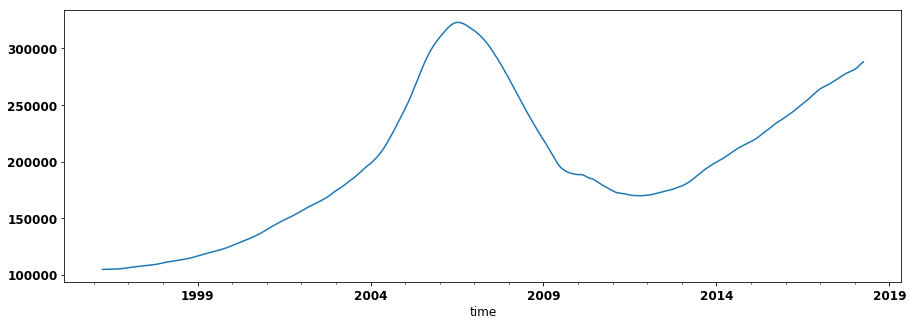

In [40]:
# Florida monthly means ovre the years
florida_monthly = df_fl.groupby(pd.Grouper(freq='MS'))
florida_monthly.value.mean().plot(figsize=(15,5))

In [41]:
# Separate out the areas that are part of Central Florida
central_florida = ['Levy', 'Marion', 'Volusia', 'Citrus', 'Sumter',
                           'Lake', 'Seminole', 'Hernando', 'Orange', 'Brevard', 'Pasco',
                           'Pinellas', 'Hillsborough', 'Polk', ' Osceola', 'Indian River']

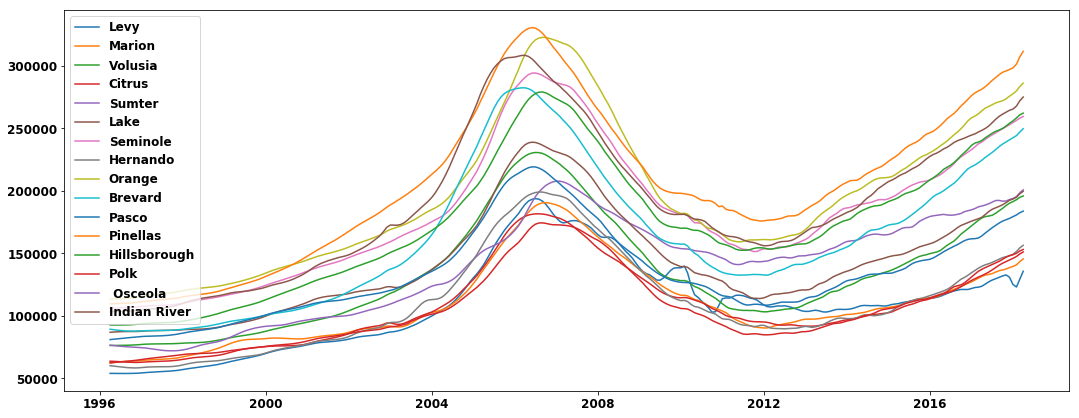

In [42]:
#Plot the means for each county in Central Florida
plt.figure(figsize=(18,7))

for county in central_florida:    
    county_df = df_fl.loc[(df_fl.CountyName==county), ['value']].resample('MS').mean()
    plt.plot(county_df, label=county)
plt.legend()
plt.show()

# df_fl_2011.loc[(df_fl_2011.CountyName=='Orange'), ['value']].resample('MS').mean()

Overall, Central FLorida's counties resemble the entire state of Florida.  Each of these counties were affected by the housing market crash, but some were affected more than others.

Based on our graph below, there appears to be some seasonality that is occurring within the housing market for orange county as time passes by.

TO create our model, we will look at the average of Central Florida's mean prices by month. 

In [43]:
central_fl = df_fl.loc[(df_fl.CountyName.isin(central_florida)), ['value']].resample('MS').mean()

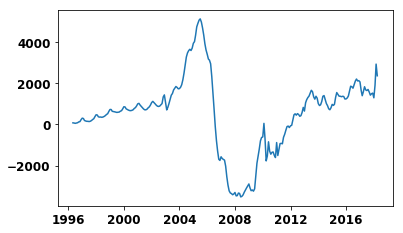

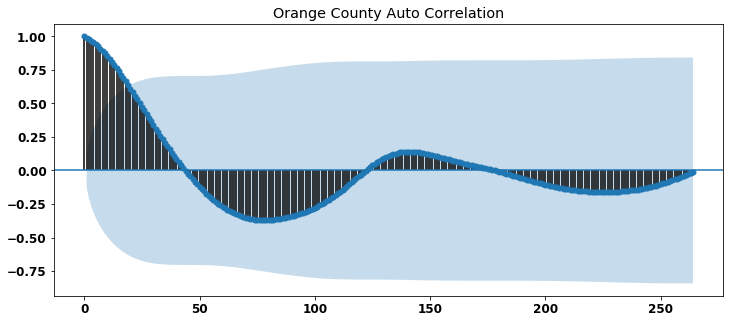

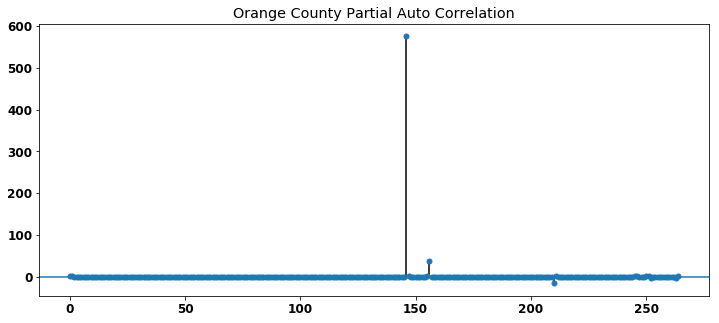

In [44]:
## Looking at difference by year
# Look at the distribution of the diffs and look at the one with the smallest standard deviation

plt.gcf().autofmt_xdate()

central_fl_diff = central_fl.diff(periods=1)
rcParams['figure.figsize'] = (12, 5)
plt.plot(central_fl_diff)

rcParams['figure.figsize'] = (12, 5)
plot_acf(central_fl['value'], title='Orange County Auto Correlation');
plot_pacf(central_fl['value'], title='Orange County Partial Auto Correlation');

Based on what we see in our partial correlation plot, there is a high negative correlation somewhere between 220 - 245 lags.

This high negative appears at lag = 180 months

In [45]:
central_fl.head()

,value
time,
1996-04-01,87852.076677
1996-05-01,87926.198083
1996-06-01,87991.693291
1996-07-01,88042.492013
1996-08-01,88106.389776


# ARIMA Modeling

Before getting into the ARIMA modeling, combinations for the model needs to be created.  
Here, the parameters for all combinations of seasons are also added to our values for seasonal & non seasonal arima modeling.

In [46]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Generate combinations of SARIMA modeling with different seasonalities
pdqs = []    
for i in range(0,13):
    for x in pdq:
        pdqs.append((x[0], x[1], x[2], i))

pdqs

[(0, 0, 0, 0),
 (0, 0, 1, 0),
 (0, 1, 0, 0),
 (0, 1, 1, 0),
 (1, 0, 0, 0),
 (1, 0, 1, 0),
 (1, 1, 0, 0),
 (1, 1, 1, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 1),
 (0, 1, 0, 1),
 (0, 1, 1, 1),
 (1, 0, 0, 1),
 (1, 0, 1, 1),
 (1, 1, 0, 1),
 (1, 1, 1, 1),
 (0, 0, 0, 2),
 (0, 0, 1, 2),
 (0, 1, 0, 2),
 (0, 1, 1, 2),
 (1, 0, 0, 2),
 (1, 0, 1, 2),
 (1, 1, 0, 2),
 (1, 1, 1, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 3),
 (0, 1, 0, 3),
 (0, 1, 1, 3),
 (1, 0, 0, 3),
 (1, 0, 1, 3),
 (1, 1, 0, 3),
 (1, 1, 1, 3),
 (0, 0, 0, 4),
 (0, 0, 1, 4),
 (0, 1, 0, 4),
 (0, 1, 1, 4),
 (1, 0, 0, 4),
 (1, 0, 1, 4),
 (1, 1, 0, 4),
 (1, 1, 1, 4),
 (0, 0, 0, 5),
 (0, 0, 1, 5),
 (0, 1, 0, 5),
 (0, 1, 1, 5),
 (1, 0, 0, 5),
 (1, 0, 1, 5),
 (1, 1, 0, 5),
 (1, 1, 1, 5),
 (0, 0, 0, 6),
 (0, 0, 1, 6),
 (0, 1, 0, 6),
 (0, 1, 1, 6),
 (1, 0, 0, 6),
 (1, 0, 1, 6),
 (1, 1, 0, 6),
 (1, 1, 1, 6),
 (0, 0, 0, 7),
 (0, 0, 1, 7),
 (0, 1, 0, 7),
 (0, 1, 1, 7),
 (1, 0, 0, 7),
 (1, 0, 1, 7),
 (1, 1, 0, 7),
 (1, 1, 1, 7),
 (0, 0, 0, 8),
 (0, 0, 1, 8),
 (0, 1, 0,

In [47]:
## Run multiple models with the different combination generated  for pdq & pdqs##
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = hf.model_SARIMA(df=central_fl, order=comb, s_order=combs)
            ans.append([comb, combs, mod.aic, mod.bic])
#             print('ARIMA {} x {} : AIC Calculated ={}, BIC Calculated ={}'.format(comb, combs, mod.aic, mod.bic))
        except:
            continue

After running all of the possible combinations through the seasonal ARIMA model, the results of each combination was stored in a dataframe, so that we can easily search for the optimum model.

In [48]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic', 'bic'])
ans_df

,pdq,pdqs,aic,bic
0,"(0, 0, 0)","(0, 0, 0, 0)",7090.036088,7093.612037
1,"(0, 0, 0)","(0, 0, 1, 0)",6872.806440,6879.950749
2,"(0, 0, 0)","(1, 0, 0, 0)",4713.930258,4721.082156
3,"(0, 0, 0)","(1, 0, 1, 0)",4352.493231,4363.209693
4,"(0, 0, 0)","(0, 0, 0, 1)",7090.036088,7093.612037
5,"(0, 0, 0)","(0, 0, 1, 1)",6872.806440,6879.950749
6,"(0, 0, 0)","(0, 1, 0, 1)",4714.914364,4718.486518
7,"(0, 0, 0)","(0, 1, 1, 1)",4353.738444,4360.875133
8,"(0, 0, 0)","(1, 0, 0, 1)",4713.930258,4721.082156
9,"(0, 0, 0)","(1, 0, 1, 1)",4352.493231,4363.209693


Here we see that the our best model has both the highest `aic`and `bic` scores.

In [49]:
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 10)
aic           3334.86
bic            3352.3
Name: 783, dtype: object

In [50]:
ans_df.loc[ans_df['bic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 10)
aic           3334.86
bic            3352.3
Name: 783, dtype: object

In [51]:
ans_df.sort_values(by=['aic','bic'], ascending=True, inplace=True)
ans_df.head(10)

,pdq,pdqs,aic,bic
783,"(1, 1, 1)","(1, 1, 1, 10)",3334.859050,3352.303738
775,"(1, 1, 1)","(1, 1, 1, 9)",3368.600960,3386.086801
791,"(1, 1, 1)","(1, 1, 1, 11)",3370.722811,3388.126005
790,"(1, 1, 1)","(1, 1, 0, 11)",3373.819459,3387.758647
787,"(1, 1, 1)","(0, 1, 1, 11)",3377.425252,3391.347807
771,"(1, 1, 1)","(0, 1, 1, 9)",3380.857172,3394.845845
767,"(1, 1, 1)","(1, 1, 1, 8)",3392.524334,3410.050992
799,"(1, 1, 1)","(1, 1, 1, 12)",3393.598775,3410.960128
782,"(1, 1, 1)","(1, 1, 0, 10)",3403.494599,3417.466845
690,"(1, 1, 0)","(1, 1, 0, 11)",3407.564192,3418.018583


Now that we have the results from our SARIMA model, we will now take the results with best AIC and BIC and pass it into our Model to see how ti performed compared to the others

Fitting ARIMA Time Series Model 

In [52]:
### Get the results of our best parameters for our ARIMA model ###
order = ans_df.loc[ans_df['aic'].idxmin()]['pdq']
s_order = ans_df.loc[ans_df['aic'].idxmin()]['pdqs']
SARIMA_MODEL = hf.model_SARIMA(central_fl, order=order, s_order=s_order, print_table=True)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9850      0.014     69.530      0.000       0.957       1.013
ma.L1          0.4889      0.031     15.526      0.000       0.427       0.551
ar.S.L10       0.0283      0.014      1.999      0.046       0.001       0.056
ma.S.L10      -0.9909      0.359     -2.762      0.006      -1.694      -0.288
sigma2      4.842e+04   1.53e+04      3.155      0.002    1.83e+04    7.85e+04


Now, we are going to take a look where some of the residuals are deviating from the standard deviation and attempt to create a batter model with

### Plottting residuals 

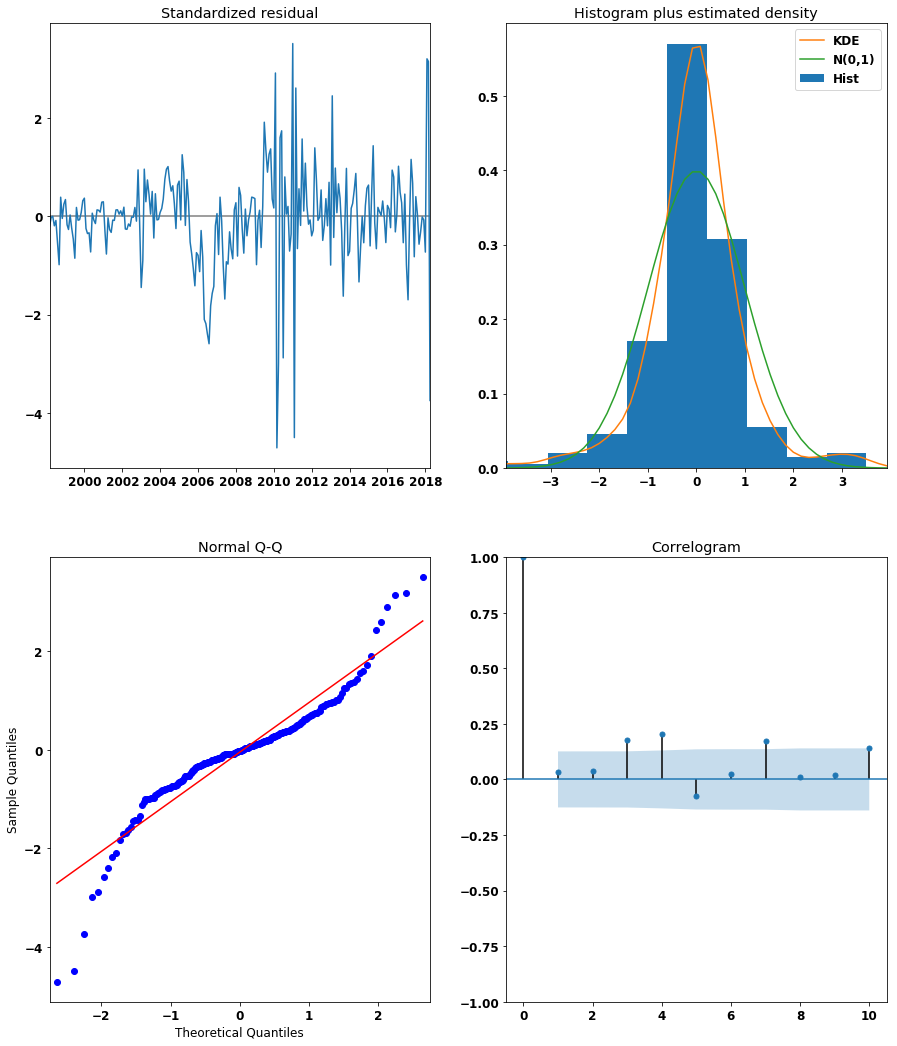

In [53]:
hf.diagnostics_plot(model=SARIMA_MODEL)

Based on the results of the plot diagnostics, we see that our data is not normally distributed. From here, we will continue to further look into our model and attempt to improve the results by removing outliers and the residuals that are causing issues within our model.

## Making predictions using our model parameters 

In [54]:
central_fl.idxmin()

value   1996-04-01
dtype: datetime64[ns]

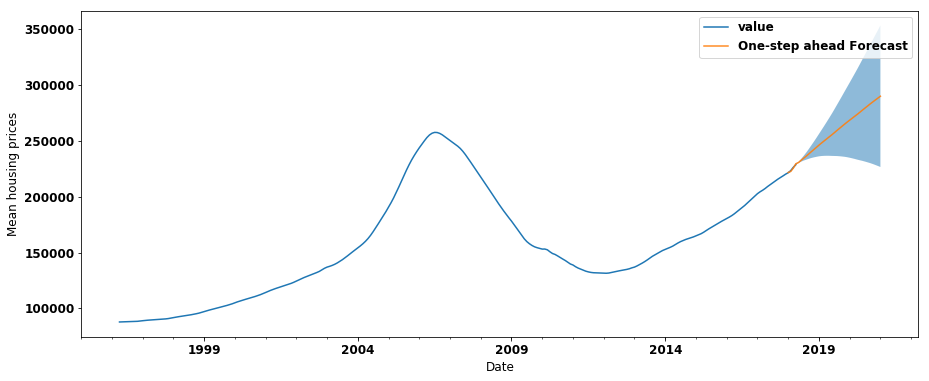

In [55]:
hf.one_step_ahead_forecast(df=central_fl, start_date='2018', end_date='2021', arima_model=SARIMA_MODEL)

### Dynamic forecasting of the data


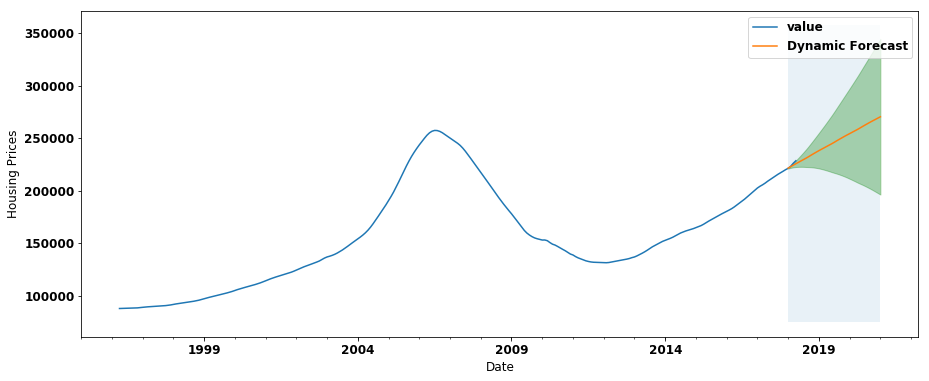

In [56]:
hf.dynamic_prediction(df=central_fl, start_date='2018', end_date='2021', arima_model=SARIMA_MODEL)

Based on the results of our dynamic prediction, the housign prices are forecast to steadily increase into 2025

## Findng the best zip code within Orange County

To find the best zip code within the given area, we wil use the following formula to calculate the return of investment:

$$\large R.O.I = \frac{(GFI - CoI)}{CoI}$$

- ROI = Return of Investment
- GFI = Gain from Investment
- CoI = Cost of Investment

Our Cost of Ivestment will be the average of 2017, since we do not have a complete dataset for 2018


To calculate GFI, we will take our cost of investment and subtract it from the average predicted means from 2018 to 2025.

We will then use the formula above to calculate the return of investment for each zip code observed

In [57]:
## Zipcodes of Orange County, Florida
zipcodes = df_fl.loc[(df_fl.CountyName.isin(central_florida))].RegionName.unique()

In [58]:
ROI_list = []
model_list = []

## Loop to get each zip code and calculate return on ivestment ##
for code in zipcodes:

    zip_df = df_fl.loc[(df_fl.RegionName==code), ['value']].resample('MS').mean()
    zip_model = hf.model_SARIMA(zip_df, order=order, s_order=s_order)

    pred = zip_model.get_prediction(start=pd.to_datetime('2018'), end=pd.to_datetime('2021'))

    ## Define the initial cost of investment as of 2017 ##
    cost_of_investment = zip_df['2017'].value.mean()

    ## Calculate gain from investmnt from 2018 up to 2021 ##
    gain_from_investment = pred.predicted_mean['2018':].mean()

    ## calculate Return of Investment for the observed zip code
    ROI = (gain_from_investment - cost_of_investment)/cost_of_investment
    ROI_list.append(ROI)
    model_list.append(zip_model)

In [59]:
df_results = pd.DataFrame(data=list(zip(zipcodes, ROI_list, model_list)), columns=['zip_code','ROI','model'])

# Step 6: Interpreting Results

Based on the results of our model, the top 5 zip codes to purchase a house from 2018-2025 are as follows:
    

In [60]:
df_results.sort_values(by='ROI', ascending=False, inplace=True)
df_results['county'] = df_results.zip_code.apply(
    lambda x: df_fl[df_fl.RegionName==x].CountyName.unique())

In [61]:
df_results.head()

,zip_code,ROI,model,county
223,34785,0.821538,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Sumter]
79,34652,0.729564,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Pasco]
122,34691,0.642348,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Pasco]
239,34488,0.580343,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Marion]
212,34690,0.561948,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Pasco]


Zip code: 34785 
County: ['Sumter']


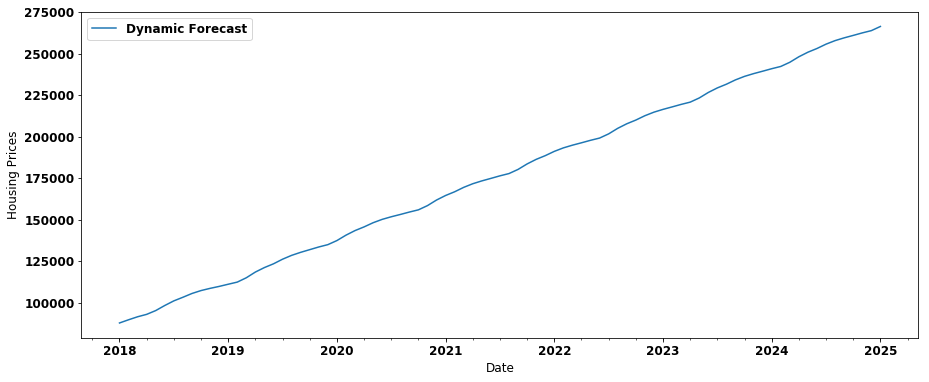

Zip code: 34652 
County: ['Pasco']


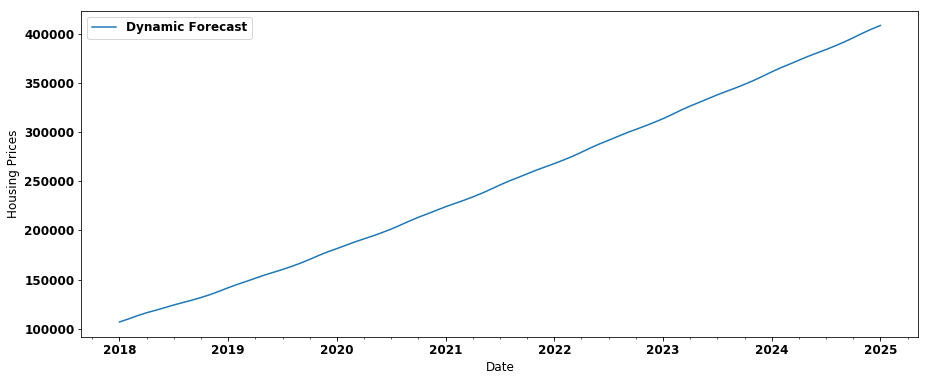

Zip code: 34691 
County: ['Pasco']


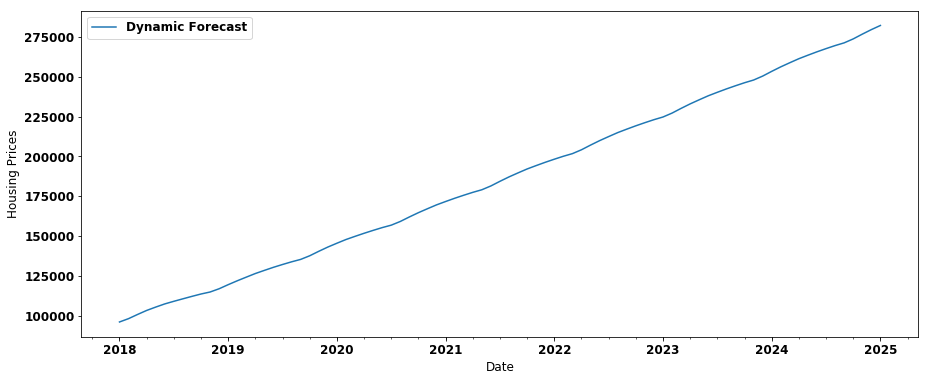

Zip code: 34488 
County: ['Marion']


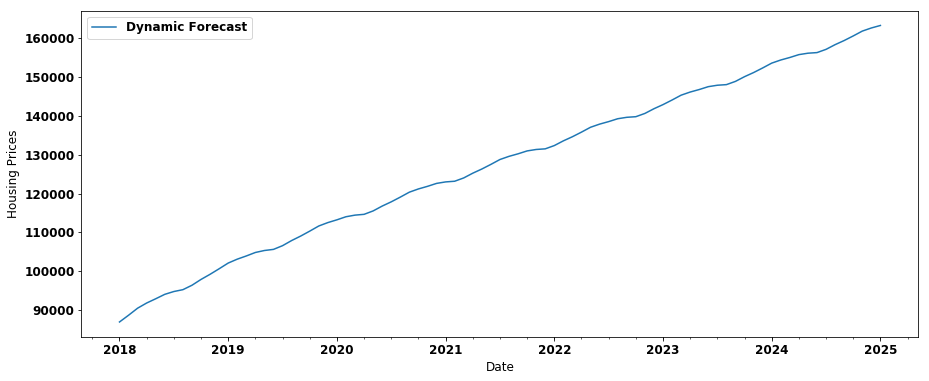

Zip code: 34690 
County: ['Pasco']


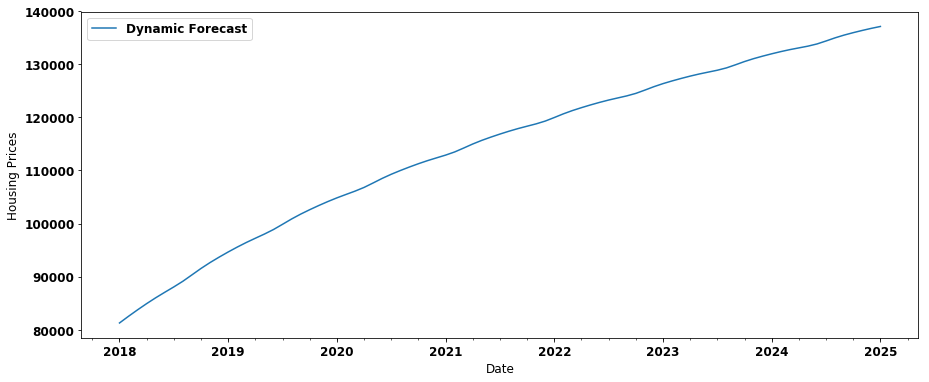

In [62]:
## Loop and code to get the 

for index, row in df_results.head().iterrows():
    zip_df = df_fl.loc[(df_fl.RegionName==code), ['value']].resample('MS').mean()
    print(f'Zip code: {row["zip_code"]} \nCounty: {row["county"]}')
    hf.dynamic_prediction(df=zip_df, start_date='2018', end_date='2025', 
                               arima_model=row['model'], plot_interval=False, plot_df=False)


In [63]:
df_results.tail()

,zip_code,ROI,model,county
178,32836,0.051416,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Orange]
222,33715,0.040957,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Pinellas]
282,34484,0.014895,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Sumter]
95,33626,0.013987,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Hillsborough]
210,33598,-0.009668,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,[Hillsborough]


Zip code: 32836 
County: ['Orange']


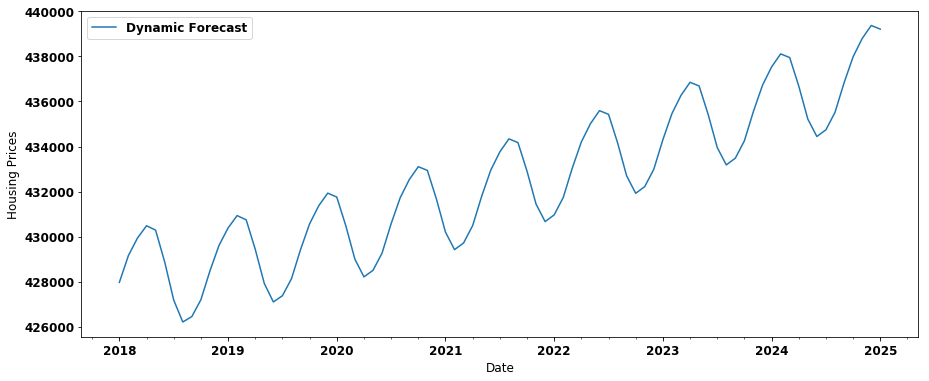

Zip code: 33715 
County: ['Pinellas']


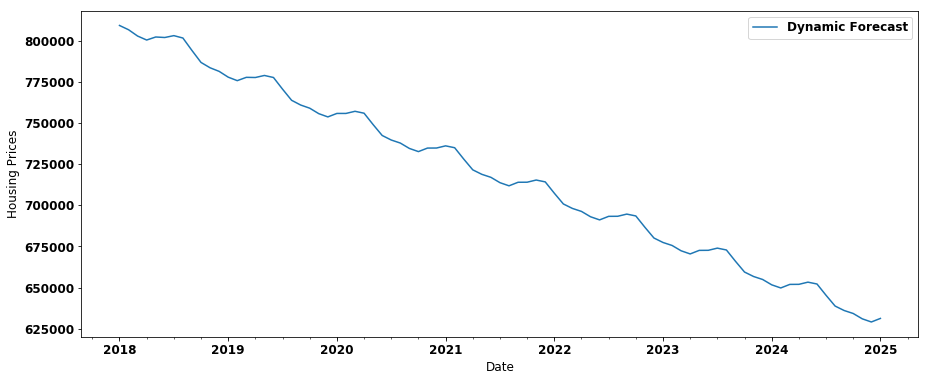

Zip code: 34484 
County: ['Sumter']


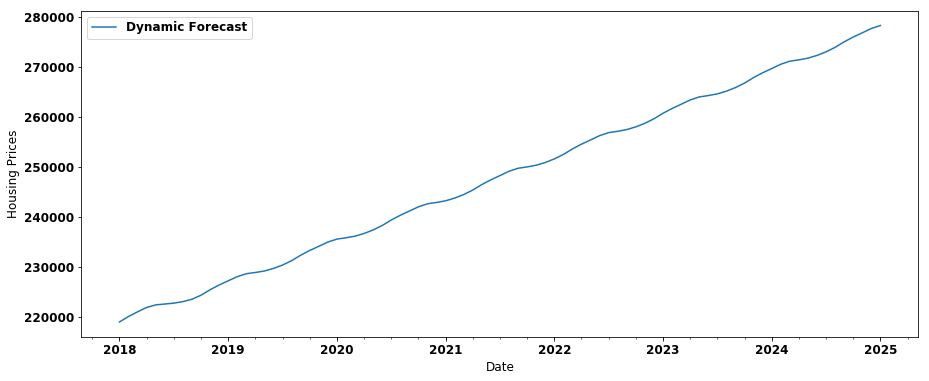

Zip code: 33626 
County: ['Hillsborough']


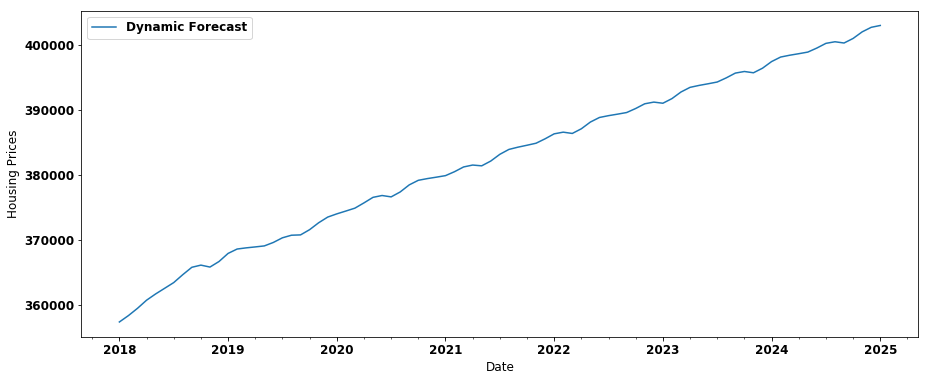

Zip code: 33598 
County: ['Hillsborough']


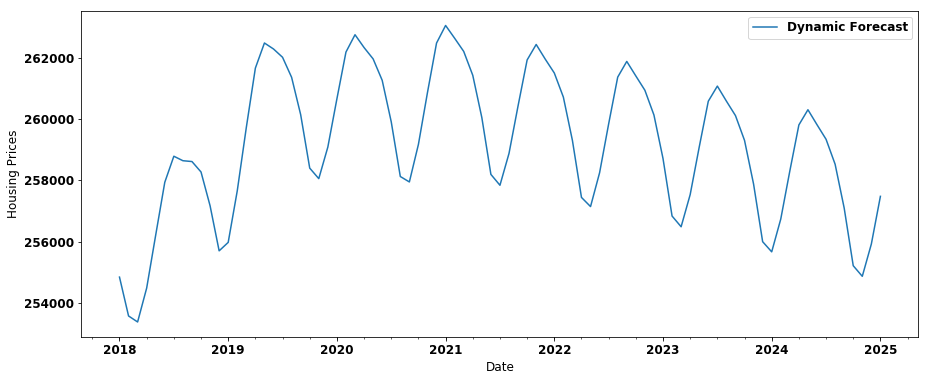

In [64]:
for index, row in df_results.tail().iterrows():
    zip_df = df_fl.loc[(df_fl.RegionName==code), ['value']].resample('MS').mean()
    print(f'Zip code: {row["zip_code"]} \nCounty: {row["county"]}')
    hf.dynamic_prediction(df=zip_df, start_date='2018', end_date='2025', arima_model=row['model'],
                         plot_interval=False, plot_df=False)


## Conclusion

Based on the results of our modeling and testing, the best zip code to invest in is 34785 of Sumter County.
My recommmendation would be to purchase homes within the area code of 34785 of Sumter County.

## Future Works

In the future, I would like to implement a means to automatically optimize the models generated, to see if the best model maybe one that was not ranked as high as the top 5.